In [1]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [2]:
data = pd.read_csv("../Dataset/Keller2020/data.csv", header=[0,1,2])

In [3]:
table = data.transpose()
mirnas = data.iloc[:,0]
mirnas[:10]

0    hsa-miR-6879-5p
1    hsa-miR-1914-3p
2    hsa-miR-6873-3p
3    hsa-miR-6749-5p
4     hsa-miR-33b-3p
5    hsa-miR-6722-3p
6       hsa-miR-4497
7       hsa-miR-4496
8    hsa-miR-514b-5p
9       hsa-miR-4499
Name: (Disease, Case/Control, TimePoint), dtype: object

In [4]:
cases = []
controls = []
for ind in table.index:
    disease, case, time = ind
    if disease == "lung" and case == "1" and time.startswith("4"):
        cases.append(ind)
    elif case == "0":
        controls.append(ind)
cases = np.array(cases)
controls = np.array(controls)

In [5]:
len(cases), len(controls)

(10, 90)

In [6]:
table = pd.concat([table.loc[pd.Index(cases)], table.loc[pd.Index(controls)]])
table = table.apply(pd.to_numeric)
table.index = list(range(len(table)))
table.head()

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,2.586579,1.984970,1.001199,67.783431,45.543636,13.936930,2.922348,1.919755,1.648331,4.904752,...,6.458223,3.600339,5.324236,3.692770,5.988129,1.733289,1.698204,2.036009,3.083484,19.849327
1,5.713781,2.234160,1.340979,59.474093,43.752316,14.981506,4.342706,1.698204,1.521796,3.279505,...,5.098393,3.207624,5.932174,2.756462,5.444247,1.470933,1.372984,0.993762,3.732401,17.123588
2,3.136505,2.062447,1.578979,43.752316,86.866796,16.124637,3.583264,1.041020,1.297070,3.069981,...,5.355190,3.634275,4.530009,2.057463,5.394346,1.885339,2.234160,1.145478,3.501534,15.748140
3,4.530009,3.518069,1.330037,38.233211,9.846221,6.816893,2.545676,1.542517,1.443457,5.988129,...,1.735977,1.411522,2.221556,2.992363,1.989384,2.687550,3.839025,1.793884,1.774053,8.740521
4,4.936459,2.046543,1.279034,43.752316,67.783431,16.814796,2.992363,1.287495,1.365078,3.802587,...,6.091902,3.436918,5.211109,2.595168,6.929546,1.122668,1.167561,1.030004,2.832109,31.096088


In [7]:
controls = np.array(len(cases)*[0] + len(controls)*[1])

### Drop NAN

In [8]:
sick = 1 - controls

In [9]:
table = table.fillna(table.min().min())

### T-test

In [10]:
X = table

In [11]:
X.columns

RangeIndex(start=0, stop=435, step=1)

In [12]:
X_healthy, X_cancer = X[controls == 1], X[controls == 0]

In [13]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [14]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [15]:
mirnas[lowest], pvalues

(305        hsa-miR-575
 328       hsa-miR-4459
 396    hsa-miR-6821-5p
 71        hsa-miR-6090
 320    hsa-miR-4707-3p
 Name: (Disease, Case/Control, TimePoint), dtype: object,
 array([5.75871069e-08, 3.84501531e-06, 4.47950703e-06, 4.56542487e-05,
        4.83878188e-05]))

### F-test

In [16]:
t3 = table

In [17]:
f, p = f_classif(t3, sick)

In [18]:
np.mean(p)

0.43409167750092675

### ANOVA

In [19]:
t3

,0,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,2.586579,1.984970,1.001199,67.783431,45.543636,13.936930,2.922348,1.919755,1.648331,4.904752,...,6.458223,3.600339,5.324236,3.692770,5.988129,1.733289,1.698204,2.036009,3.083484,19.849327
1,5.713781,2.234160,1.340979,59.474093,43.752316,14.981506,4.342706,1.698204,1.521796,3.279505,...,5.098393,3.207624,5.932174,2.756462,5.444247,1.470933,1.372984,0.993762,3.732401,17.123588
2,3.136505,2.062447,1.578979,43.752316,86.866796,16.124637,3.583264,1.041020,1.297070,3.069981,...,5.355190,3.634275,4.530009,2.057463,5.394346,1.885339,2.234160,1.145478,3.501534,15.748140
3,4.530009,3.518069,1.330037,38.233211,9.846221,6.816893,2.545676,1.542517,1.443457,5.988129,...,1.735977,1.411522,2.221556,2.992363,1.989384,2.687550,3.839025,1.793884,1.774053,8.740521
4,4.936459,2.046543,1.279034,43.752316,67.783431,16.814796,2.992363,1.287495,1.365078,3.802587,...,6.091902,3.436918,5.211109,2.595168,6.929546,1.122668,1.167561,1.030004,2.832109,31.096088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.515659,2.668237,1.873708,41.641526,78.550614,17.480883,3.387908,2.215011,1.401626,7.171026,...,3.768511,2.460019,4.127907,3.179283,2.747371,2.288662,2.887993,1.603383,2.877183,14.728697
96,10.232273,4.318441,1.753664,59.474093,32.288977,9.047622,6.144896,3.786425,1.989384,9.158041,...,2.246905,1.619397,3.653340,3.006228,2.595168,4.019735,4.680239,3.207624,1.453367,5.280803
97,11.293200,3.306345,1.591532,25.013250,86.866796,20.897139,5.932174,2.561605,1.612476,9.942280,...,3.470185,2.344041,3.977985,5.444247,3.953678,1.393112,3.996203,1.777235,2.898270,13.128558
98,7.591676,3.406488,2.435394,27.763915,82.654551,16.814796,4.710073,2.612104,1.915322,18.361865,...,3.263780,2.799438,3.533895,5.098393,2.648312,2.561605,2.767663,1.937086,2.502052,10.621846


In [20]:
X = np.array(sick).reshape(-1, 1)

In [21]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [22]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.020233107841534

### Mean-variance-plot

In [23]:
np.mean(table)

0       6.657163
1       2.863022
2       2.199485
3      38.315493
4      78.551490
         ...    
430     2.129146
431     2.615476
432     1.746984
433     2.805027
434    16.521241
Length: 435, dtype: float64

In [24]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [25]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

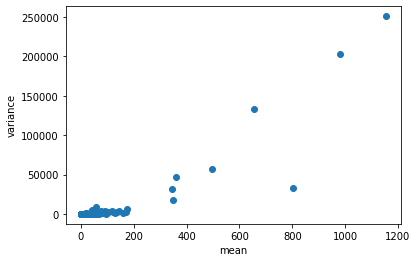

In [26]:
mean_variance_plot(table)

### Log transformation

In [27]:
log_table = table#np.log2(table)

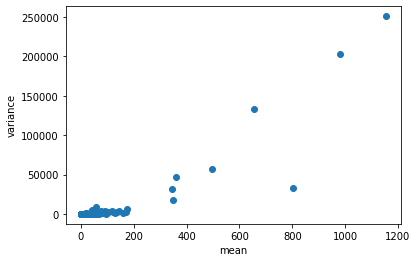

In [28]:
mean_variance_plot(log_table)

### Remove mean

In [29]:
norm_log_table = log_table #- np.mean(log_table)
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

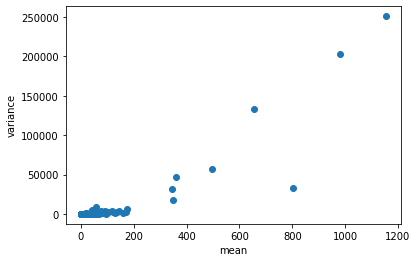

In [30]:
mean_variance_plot(norm_log_table)

### PCA

In [31]:
pca = decomposition.PCA(n_components=10)

In [32]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [33]:
pca.explained_variance_ratio_

array([0.48526022, 0.22002531, 0.11566534, 0.0498943 , 0.04223555,
       0.02198585, 0.01838795, 0.01261068, 0.00645251, 0.00595828])

In [34]:
components = pca.transform(norm_log_table)

In [35]:
components.shape

(100, 10)

In [36]:
sum(controls)

90

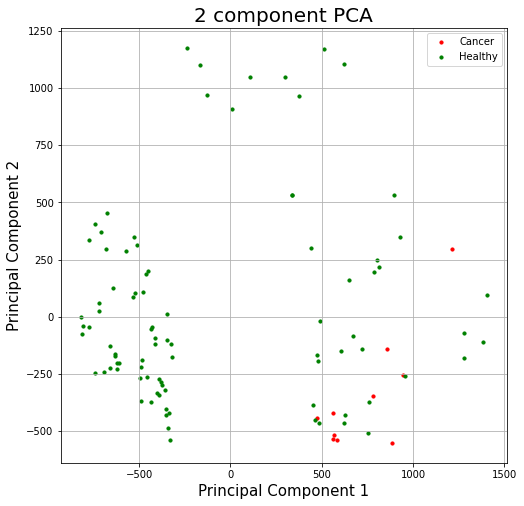

In [37]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [38]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

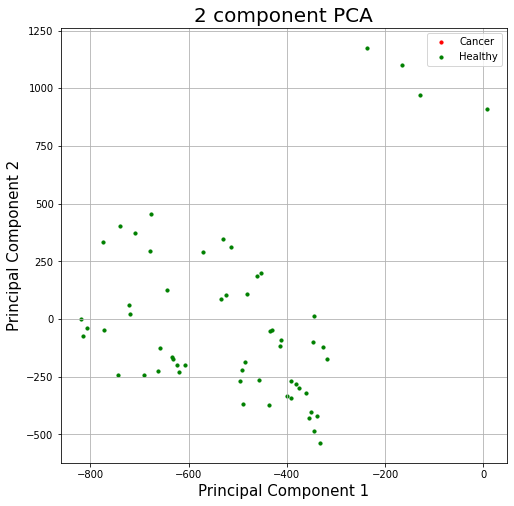

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [40]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [41]:
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


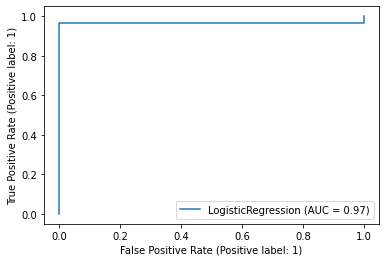

In [42]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [43]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:34:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


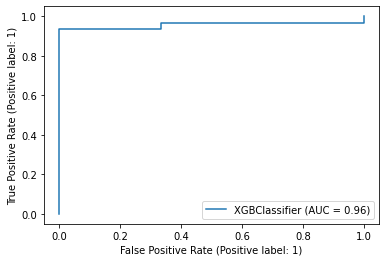

In [44]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [45]:
mirnas[:10]

0    hsa-miR-6879-5p
1    hsa-miR-1914-3p
2    hsa-miR-6873-3p
3    hsa-miR-6749-5p
4     hsa-miR-33b-3p
5    hsa-miR-6722-3p
6       hsa-miR-4497
7       hsa-miR-4496
8    hsa-miR-514b-5p
9       hsa-miR-4499
Name: (Disease, Case/Control, TimePoint), dtype: object

In [46]:
from Scripts import converters

In [47]:
sequences = converters.canonical_to_seq(mirnas)

In [48]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,CAGGGCAGGGAAGGUGGGAGAG,GGAGGGGUCCCGCACUGGGAGG,UUCUCUCUGUCUUUCUCUCUCAG,UCGGGCCUGGGGUUGGGGGAGC,CAGUGCCUCGGCAGUGCAGCCC,UGCAGGGGUCGGGUGGGCCAGG,CUCCGGGACGGCUGGGC,GAGGAAACUGAAGCUGAGAGGG,UUCUCAAGAGGGAGGCAAUCAU,AAGACUGAGAGGAGGGA,...,AAGCCCUUACCCCAAAAAGCAU,UGAUUGUCUUCCCCCACCCUCA,GGCUACAACACAGGACCCGGGC,ACACUGUCCCCUUCUCCCCAG,UGUGUGGAUCCUGGAGGAGGCA,UGUGGGUUCUGGGUUGGGGUGA,AAAGACCCAUUGAGGAGAAGGU,CAGCCUCUGCCCUUGGCCUCC,UCGCCUCCUCCUCUCCC,cancer
0,2.586579,1.984970,1.001199,67.783431,45.543636,13.936930,2.922348,1.919755,1.648331,4.904752,...,3.600339,5.324236,3.692770,5.988129,1.733289,1.698204,2.036009,3.083484,19.849327,1
1,5.713781,2.234160,1.340979,59.474093,43.752316,14.981506,4.342706,1.698204,1.521796,3.279505,...,3.207624,5.932174,2.756462,5.444247,1.470933,1.372984,0.993762,3.732401,17.123588,1
2,3.136505,2.062447,1.578979,43.752316,86.866796,16.124637,3.583264,1.041020,1.297070,3.069981,...,3.634275,4.530009,2.057463,5.394346,1.885339,2.234160,1.145478,3.501534,15.748140,1
3,4.530009,3.518069,1.330037,38.233211,9.846221,6.816893,2.545676,1.542517,1.443457,5.988129,...,1.411522,2.221556,2.992363,1.989384,2.687550,3.839025,1.793884,1.774053,8.740521,1
4,4.936459,2.046543,1.279034,43.752316,67.783431,16.814796,2.992363,1.287495,1.365078,3.802587,...,3.436918,5.211109,2.595168,6.929546,1.122668,1.167561,1.030004,2.832109,31.096088,1


In [49]:
norm_log_table.to_csv("../TransformedData/Keller2020_raw.csv", index=False)